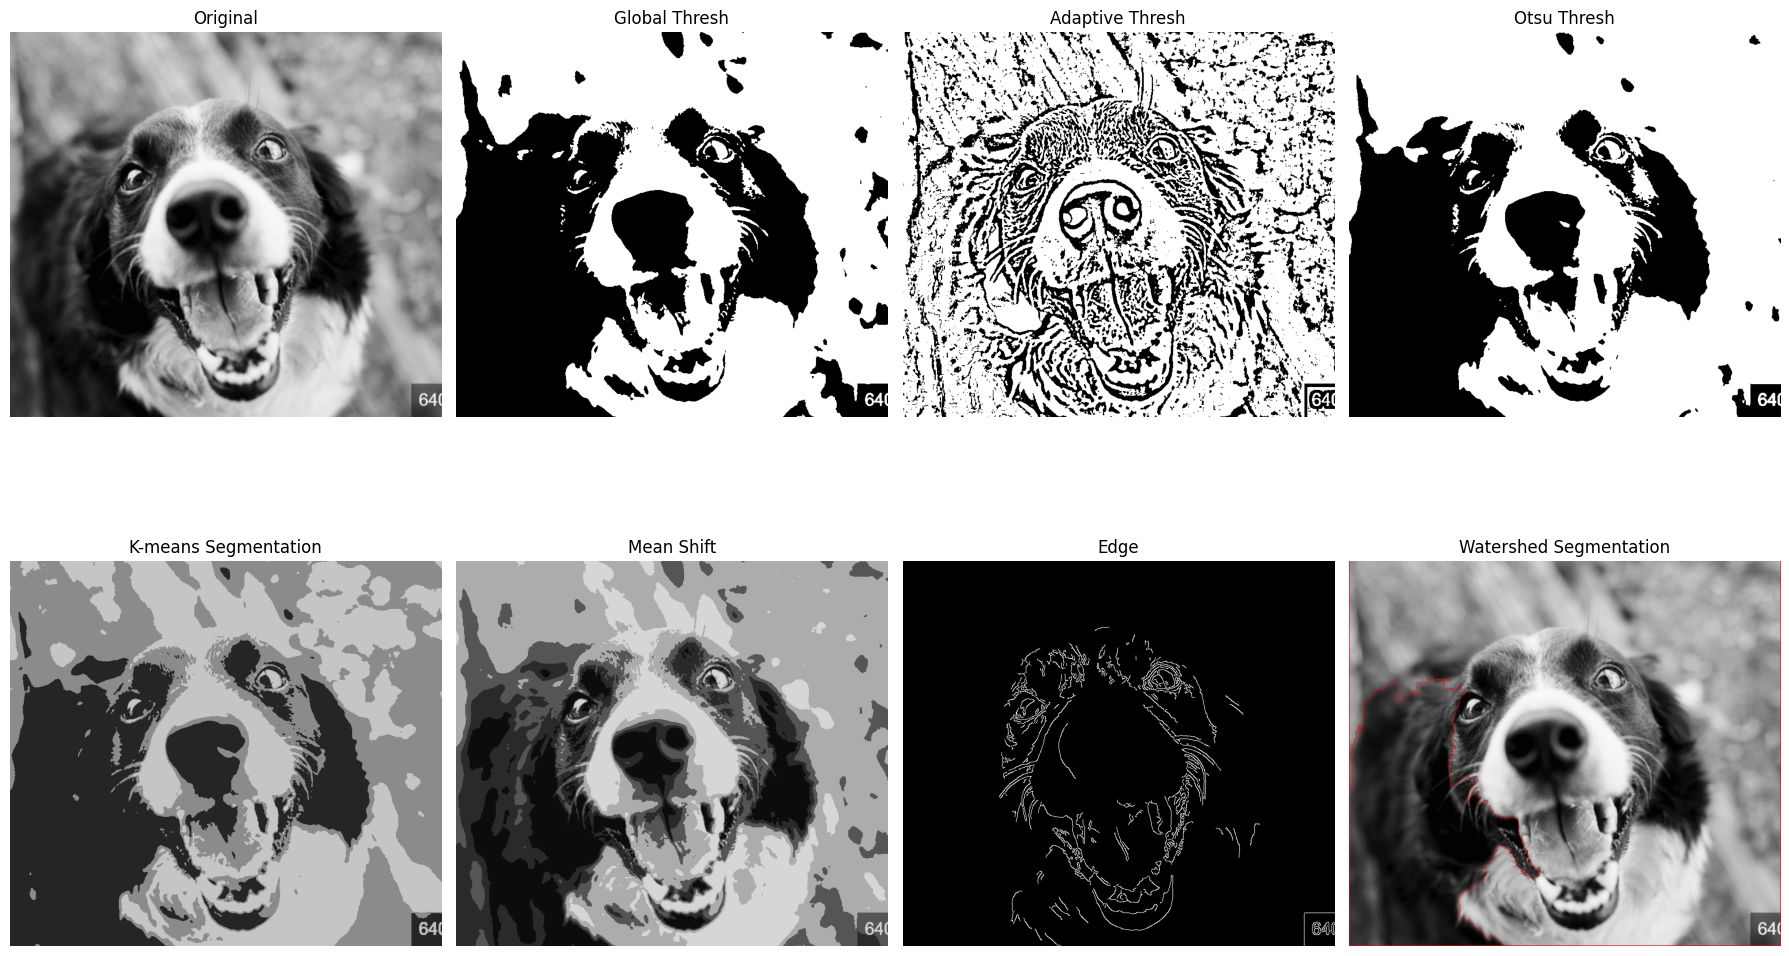

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, color, filters
from sklearn.cluster import MeanShift, estimate_bandwidth
import torch
import segmentation_models_pytorch as smp

img = cv2.imread("IMAGE.PNG")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


_, global_thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Adaptive Threshold
adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                        cv2.THRESH_BINARY, 11, 2)

# Otsu Threshold
_, otsu_thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# ---------------- K-means Segmentation ----------------
z = img_rgb.reshape((-1, 3))
z = np.float32(z)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
k = 3
_, labels, centers = cv2.kmeans(z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
kmeans_seg = centers[labels.flatten()].reshape(img_rgb.shape)

# ---------------- Canny Edge Detection ----------------
edges = cv2.Canny(gray, 100, 200)

# ---------------- Mean Shift Segmentation ----------------
flat_img = img_rgb.reshape((-1, 3))
bandwidth = estimate_bandwidth(flat_img, quantile=0.1, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(flat_img)
labels_ms = ms.labels_
cluster_centers = ms.cluster_centers_.astype(np.uint8)
mean_shift_seg = cluster_centers[labels_ms].reshape(img_rgb.shape)

# ---------------- Watershed Segmentation ----------------
# Threshold + Noise removal
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Background and Foreground
sure_bg = cv2.dilate(opening, kernel, iterations=3)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown==255] = 0
img_watershed = img_rgb.copy()
markers = cv2.watershed(img_watershed, markers)
img_watershed[markers == -1] = [255, 0, 0]
titles = ["Original", "Global Thresh", "Adaptive Thresh", "Otsu Thresh",
          "K-means Segmentation", "Mean Shift", "Edge", "Watershed Segmentation"]
images = [img_rgb, global_thresh, adaptive_thresh, otsu_thresh,
          kmeans_seg, mean_shift_seg, edges, img_watershed]

plt.figure(figsize=(18,12))
for i in range(len(images)):
    plt.subplot(2, 4, i+1)
    cmap = "gray" if i in [1,2,3,6] else None
    plt.imshow(images[i], cmap=cmap)
    plt.title(titles[i])
    plt.axis("off")
plt.tight_layout()
plt.show()
